**Data Collection using pandas reader**

In [51]:
##Data Collection for stocks using pandas_datareader library 
import pandas_datareader as pdr

In [52]:
##Create an account at https://api.tiingo.com/ to get stock data by hitting tingo API
##Storing the stock history data of Apple in a dataframe df by calling get_data_tiingo method
key='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
df=pdr.get_data_tiingo('AAPL',api_key=key)

In [53]:
df.to_csv('AAPL.csv')

In [54]:
import pandas as pd
df=pd.read_csv('AAPL.csv')

In [55]:
##Subsetting the data, only using closing values
df1=df.reset_index()['close']

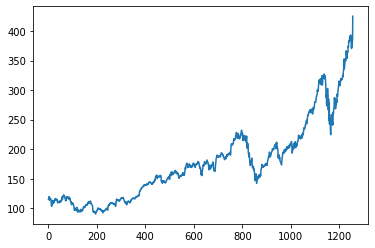

In [56]:
##Plotting the closing values of the Stock
import matplotlib.pyplot as plt
plt.plot(df1)

In [57]:
##Scaling the data in the range of 0 to 1 before passing to the LSTM Model, Since LSTM is sensitive to scale
##We apply Min Max Scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [58]:
##Now the closing values are converted in the range between 0 and 1
print(df1)

[[0.07487302]
 [0.07406633]
 [0.07523155]
 ...
 [0.86590977]
 [0.87965342]
 [1.        ]]


**Data Partition (Train - Test Split)**


*Time Series Intuition:*
Time series data points are dependent on previous day's values.
Hence Splitting the data to train and test should be splitted in such a way that the order is preserved based on date.

ex:  Date  - Closing Price

1.   01-jun - 332,
2.   02-jun - 331,
3.   03-jun - 335,
4.   04-jun - 334,
5.   05-jun - 333


while splitting the above data we could not use random split we can divide in a way that order is maintained

Train- 
*   01-jun - 330
*   02-jun - 332
*   03-jun - 331
*   04-jun - 335


Test -
  

*   05-jun - 334,
*   06-jun - 333



In [59]:
##Splitting the data into train and test split
##First 70% goes to train data, remaining 30% test data
train_size=int(len(df1)*0.70)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:]

**Time Steps Intuition:**
*Consider Train Data:* 330, 332, 331, 335
*Consider Test Data :* 334, 333, 334, 336

When we set Time_Steps =2
Our model takes into consideration two values before the current timestamp for predicting new stock value. It works like an iteration one step forward but consider 2 consecutive values since time_Step=2

***Note: Usually choosing higher time_step gives better prediction***

    

*   x1     x2     y_train (Output)  
*   330    332     331
*   332    331     335
*   331    335     333

Similarly for Test data
*   x1     x2     y_test (Output)  
*   334    333     334
*   333    334     336






In [60]:
##Creating a function to implement the above logic through a for loop iteration
import numpy as np

def dataset(data,time_step):

  xdata,ydata=[],[]
  for i in range(0,len(data)-time_step-1):
  
    a=data[i:(i+time_step)]
    b=data[i+time_step]
    xdata.append(a)
    ydata.append(b)

  return np.array(xdata),np.array(ydata)
  

In [61]:
##Choosing a bigger time_step value usually provides a stable and better prediction
time_step=100
X_train,Y_train=dataset(train_data,time_step)
X_test,Y_test=dataset(test_data,time_step)
print((X_train.shape)) ##X_train has 779 records with time_step=100 features in it 
print((Y_train.shape)) ##Y_train has just the 779 target records

(778, 100, 1)
(778, 1)


In [62]:
##Optional
##Make sure to Reshape the training data and testing data into a 3 dimensional if the data is in 2 dimensional form susceptible for LSTM to process
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

**Create a Stacked LSTM Model**

In [63]:
## Importing the required libraries to Create the Stacked LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) ## Choosing 50 hidden layers, input shape as 100,1 as like our input dimension in previous step
model.add(LSTM(50,return_sequences=True)) ##Since this is a stacked LSTM we add one LSTM after the other
model.add(LSTM(50))
model.add(Dense(1)) ##Final Output Layer
model.compile(loss='mean_squared_error',optimizer='adam')

In [64]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [65]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(778, 100, 1)
(778, 1)
(277, 100, 1)
(277, 1)


In [66]:
##Fitting our LSTM model over the prepared training data
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=70,verbose=1)

##Decrease in Loss in every iteration is a good sign that our model reduces errors in every iteration

Epoch 1/100
12/12 [==============================] - 3s 247ms/step - loss: 0.0117 - val_loss: 0.0631
Epoch 2/100
12/12 [==============================] - 2s 191ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 3/100
12/12 [==============================] - 2s 192ms/step - loss: 9.2091e-04 - val_loss: 0.0027
Epoch 4/100
12/12 [==============================] - 2s 192ms/step - loss: 5.6712e-04 - val_loss: 0.0054
Epoch 5/100
12/12 [==============================] - 2s 191ms/step - loss: 5.3455e-04 - val_loss: 0.0059
Epoch 6/100
12/12 [==============================] - 2s 189ms/step - loss: 4.8849e-04 - val_loss: 0.0049
Epoch 7/100
12/12 [==============================] - 2s 190ms/step - loss: 4.8389e-04 - val_loss: 0.0063
Epoch 8/100
12/12 [==============================] - 2s 190ms/step - loss: 4.8255e-04 - val_loss: 0.0064
Epoch 9/100
12/12 [==============================] - 2s 193ms/step - loss: 4.5493e-04 - val_loss: 0.0059
Epoch 10/100
12/12 [==============================] - 2s 191ms/

**Prediction using Trained LSTM Model**

In [67]:
##Predict using the model in both test and train data
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [68]:
##Converting the scaled values back to original values for comparison and metrics
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [69]:
##RMSE value for comparing predicted values and actual Y_train values
##We use math.sqrt to calculate Root value(RMSE) from the Mean squared error
##Train RMSE
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_predict,Y_train))


152.2288342959666

In [70]:
##RMSE value for comparing predicted values and actual Y_test values
##Test RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

261.1220585526158

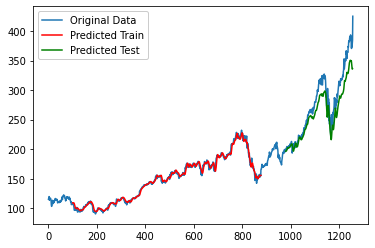

In [71]:
### Plotting 
#shift train predictions for plotting
look_back=100 ##Since our time_Step is 100 we could not predict from 0th row hence plotting the train predict from 100
trainPredictPlot = np.empty_like(df1) ##Returns an array of same shape and size of input array which we pass into this function
trainPredictPlot[:, :] = np.nan        ##Replace all the values with nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict ##Replacing the NA values with predicted values 
##for train from 100th row till final predicted values
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict ##Replacing the NA values with predicted values for test
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1),label="Original Data")

plt.plot(trainPredictPlot,"-r",label="Predicted Train")
plt.plot(testPredictPlot,'-g',label="Predicted Test")
plt.legend(framealpha=1, frameon=True);

##The blue plot shows the actual stock data
##Green plot shows the test predicted values
##Orange plot shows the train predicted values

**Forecast the Stock for future 7 Days**

In [72]:
len(test_data)

378

In [73]:
predict_input=test_data[278:].reshape(1,-1) ##Reshape (1,-1) means the target variable will now have 1 row and unknown number of columns  
##hence it takes automatically the number of available columns
predict_input.shape
forecast_input=list(predict_input)##Making the input as a list
forecast_input=forecast_input[0].tolist()
forecast_input


[0.5530026889752016,
 0.47173588288019114,
 0.5605915745443681,
 0.4537496265312219,
 0.4855691664176875,
 0.4670749925306244,
 0.46142814460711085,
 0.4149985061248879,
 0.4004481625336122,
 0.4677024200776814,
 0.463639079772931,
 0.5022408126680609,
 0.4702718852703914,
 0.49139527935464594,
 0.4898416492381236,
 0.4498655512399163,
 0.461876307140723,
 0.45135942635195686,
 0.5142814460711085,
 0.5051986853899013,
 0.5250373468778009,
 0.5307738273080369,
 0.5464893934867046,
 0.5877203465790259,
 0.579892440991933,
 0.5866447564983566,
 0.5750224081266806,
 0.5574843143113235,
 0.5319091723931879,
 0.5550044816253361,
 0.5518075888855689,
 0.5755303256647744,
 0.5761278757095907,
 0.5624141021810576,
 0.5897520167314012,
 0.6078876605915744,
 0.5937556020316701,
 0.6059755004481626,
 0.6191216014341201,
 0.6282939946220496,
 0.6375858978189424,
 0.6566776217508214,
 0.6712578428443381,
 0.6605019420376457,
 0.6492680011951,
 0.6549148491186136,
 0.6494472662085449,
 0.671108455333

In [74]:

# Prediction for next 7 days
from numpy import array
output=[]
n_steps=100
i=0
while(i<7): ##Running the loop for 7 times
    
    if(len(forecast_input)>100): ##System goes inide this block only after the second iteration since lenght of forecast_input list will go 
    ##above 100 only after 2nd iteration
        x_input=np.array(forecast_input[1:])#to shift the position 1 step to right such that subsequent 100 records are considered
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)##Remembe to reshape for LSTM to predict
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        forecast_input.extend(yhat[0].tolist())#appending the forecastinput with predicted value such that on next iteration 2:101 are considered for prediction
        forecast_input=forecast_input[1:]
        output.extend(yhat.tolist())
        i+=1
    else:    ##Systems goes inside this block during the first iteration since length of forecast_input is not greater than 100
        x_input = predict_input.reshape((1, n_steps,1)) ##Remembe to reshape for LSTM to predict
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        forecast_input.extend(yhat[0].tolist())#appending the forecastinput with predicted value such that on next iteration 2:101 are considered for prediction
        print(len(forecast_input))
        output.extend(yhat.tolist())##appending the output list with newly predicted values
        i+=1
print(output)

[0.7791228]
101
1 day input [0.47173588 0.56059157 0.45374963 0.48556917 0.46707499 0.46142814
 0.41499851 0.40044816 0.46770242 0.46363908 0.50224081 0.47027189
 0.49139528 0.48984165 0.44986555 0.46187631 0.45135943 0.51428145
 0.50519869 0.52503735 0.53077383 0.54648939 0.58772035 0.57989244
 0.58664476 0.57502241 0.55748431 0.53190917 0.55500448 0.55180759
 0.57553033 0.57612788 0.5624141  0.58975202 0.60788766 0.5937556
 0.6059755  0.6191216  0.62829399 0.6375859  0.65667762 0.67125784
 0.66050194 0.649268   0.65491485 0.64944727 0.67110846 0.66567075
 0.68386615 0.6767553  0.68285031 0.67639677 0.68051987 0.68093815
 0.68001195 0.69169405 0.6961458  0.701464   0.6930983  0.72052584
 0.72638183 0.75784284 0.78428443 0.73367195 0.74233642 0.75485509
 0.78201374 0.78054975 0.78096803 0.77496265 0.80230057 0.82518673
 0.80585599 0.82013744 0.78664476 0.81099492 0.82001793 0.81795638
 0.81795638 0.84705707 0.84359128 0.86952495 0.87442486 0.87642665
 0.87113833 0.89002091 0.89799821 0

In [80]:
day_new=np.arange(1,101)
day_pred=np.arange(101,108)
len(df1)
scaler.inverse_transform(output)

array([[351.11241101],
       [351.42400498],
       [342.65051713],
       [329.10650349],
       [313.76103424],
       [298.17219891],
       [283.06444997]])

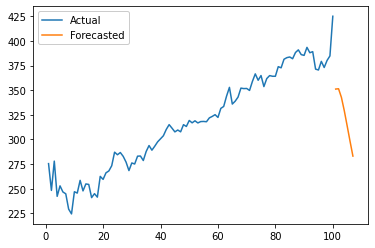

In [83]:
plt.plot(day_new,scaler.inverse_transform(df1[1157:]),label='Actual')
plt.plot(day_pred,scaler.inverse_transform(output),label='Forecasted')
plt.legend(framealpha=1,frameon=True)

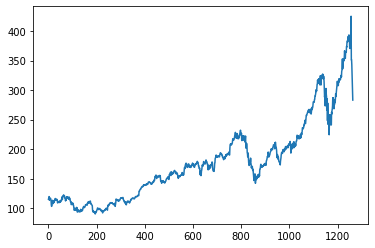

In [79]:
df3=df1.tolist()
df3.extend(output)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)